# Asteroid Route Optimization


In [1]:
from imp import reload
import sys
import os
import os.path
from glob import glob
import numpy as np
import pandas as pd
# print(sys.version)
pd.show_versions()
from scipy import stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.use14corefonts'] = True
#matplotlib.rcParams['text.usetex'] = False
# Use Type 1 fonts in plots.
matplotlib.rc('pdf', fonttype=42)
matplotlib.rcParams['font.size'] = 12
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner


INSTALLED VERSIONS
------------------
commit           : 945c9ed766a61c7d2c0a7cbb251b6edebf9cb7d5
python           : 3.8.10.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.8.0-41-generic
Version          : #46~20.04.1-Ubuntu SMP Mon Jan 18 17:52:23 UTC 2021
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_GB.UTF-8
LOCALE           : en_GB.UTF-8

pandas           : 1.3.4
numpy            : 1.20.3
pytz             : 2019.3
dateutil         : 2.7.3
pip              : 20.0.2
setuptools       : 45.2.0
Cython           : 3.0a6
pytest           : 4.6.9
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.5.0
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10.1
IPython          : 7.13.0
pandas_datareader: None
bs4              : 4.8.2
bottleneck       : None
f

In [2]:
#dfbest = pd.read_csv('best_fitness_selected.csv',sep=';')
def get_opt(instpath):
    instance_name = instpath.split('/')[-1].replace('.dat','').replace('.txt','')
    sol = dfbest[dfbest.instance_name==instance_name]
    if len(sol) != 1: 
        print("No opt value")
        return np.nan
    if sol.best_known_subdiagonal.isna().bool():
        return sol.best_known.iloc[0]
    else:
        return sol.best_known_subdiagonal.iloc[0]

def read_alldata(pat="./results/**/*.csv.xz"):
    lis = []
    for filename in glob(pat, recursive=True):
        tmp = pd.read_csv(filename)
        print(filename)
        #tmp.instance = tmp.instance.str.replace('pfsp/','pfsp_cmax/')
        if "dist_hamming" in filename:
            tmp['Distance'] = "hamming"
        elif "dist_kendall" in filename:
            tmp['Distance'] = "kendall"
        if "umm2" in filename:
             tmp['Solver'] = "UMM2"
        if "-er0" in filename:
            tmp['Solver'] += "_order"
        elif "-er1" in filename:
            tmp['Solver'] += "_rank"
        #tmp['Solver'] += '_'
        #tmp['Solver'] += tmp.budget.astype(str)
        lis.append(tmp)
    df = pd.concat(lis, sort = True)
    # Fix instance names
    df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
    df['Instance'] = df['Instance'].str.replace('.txt','', regex=False).str.replace('.dat', '', regex=False)
    # Let's include the name just to be clear in the output.
    df['instance'] = 'ARP_' + df['instance']
    return df

def check_runs(df, nruns):
    # Some algorithms only have 1 run
    df = df[~df.Solver.str.startswith("GreedyNN")] 
    df2 = df.groupby(['Solver', 'instance','Distance',"eval_ranks","budget","Function evaluations"])['seed'].sum()
    totalruns = np.arange(1, nruns + 1).sum()
    assert (df2 == totalruns).all(),f"{df2[df2 != totalruns]}"
    assert (df.groupby(['Solver', 'instance','Distance',"eval_ranks","budget","Function evaluations"])['seed'].nunique() == nruns).all()

# If runs were terminated after different number of evaluations, 
# use only the evaluations reached in all runs to avoid misleading mean and variance.
def filter_unequal_budget(df, budget):
    groups = ['Solver','instance','eval_ranks','Distance']
    df_max_evals = df[df.Solver.str.startswith("CEGO")].groupby(groups + ['seed'])['Function evaluations'].max()
    df_max_evals = df_max_evals.groupby(groups).min()
    for index,row  in df_max_evals.reset_index().iterrows():
        if row['Function evaluations'] == budget: continue
        before = df.shape[0]
        # FIXME: How to do this in a shorter manner?
        df = df[~((df.Solver == row.Solver) & (df.instance == row.instance) & (df.eval_ranks == row.eval_ranks) & (df.Distance == row.Distance) & (df['Function evaluations'] > row['Function evaluations']))]
        print(f"Removed {before - df.shape[0]} rows for Solver={row.Solver} instance={row.instance} eval_ranks={row.eval_ranks} Distance={row.Distance}")
    return df

df = read_alldata()
# This is only for synthetic LOPs
#df['Uniformity'] = df.instance.str.extract(r'phi=(.+)$').astype(float)
# These are the instances used in the paper
sel_insts = []
if sel_insts:
    df = df[(mask) & (df.instance.isin(sel_insts))]
else:
    sel_insts = np.sort(df.instance.unique())
nruns = 5
df = filter_unequal_budget(df, 1000)
df['budget'].fillna(1,inplace=True)
df['seed'].fillna(1,inplace=True)
df = df.sort_values(['Problem', 'instance', 'Solver', 'eval_ranks', 'budget','seed','Function evaluations'])
df['Best-so-far fitness'] = df.groupby(['Problem', 'instance','Solver', 'eval_ranks', 'budget','seed'])['Fitness'].cummin()
# Checks that make sure we have the correct number of runs
check_runs(df, nruns)
#df[df.Solver.str.startswith("GreedyNN")]

./results/m1-er0/arp_25_73/greedynn-r1.csv.xz
./results/m1-er0/arp_25_42/greedynn-r1.csv.xz
./results/m1-er0/arp_10_73/greedynn-r1.csv.xz
./results/m1-er0/arp_30_73/greedynn-r1.csv.xz
./results/m1-er0/arp_15_73/greedynn-r1.csv.xz
./results/m1-er0/arp_30_42/greedynn-r1.csv.xz
./results/m1-er0/arp_15_42/greedynn-r1.csv.xz
./results/m1-er0/arp_20_42/greedynn-r1.csv.xz
./results/m1-er0/arp_20_73/greedynn-r1.csv.xz
./results/m1-er0/arp_10_42/greedynn-r1.csv.xz
./results/m400-er1/arp_25_73/umm-maxmindist.csv.xz
./results/m400-er1/arp_25_73/cego.csv.xz
./results/m400-er1/arp_25_42/umm-maxmindist.csv.xz
./results/m400-er1/arp_25_42/cego.csv.xz
./results/m400-er1/arp_10_73/umm-maxmindist.csv.xz
./results/m400-er1/arp_10_73/cego.csv.xz
./results/m400-er1/arp_30_73/umm-maxmindist.csv.xz
./results/m400-er1/arp_30_73/cego.csv.xz
./results/m400-er1/arp_15_73/umm-maxmindist.csv.xz
./results/m400-er1/arp_15_73/cego.csv.xz
./results/m400-er1/arp_30_42/umm-maxmindist.csv.xz
./results/m400-er1/arp_30_42/

,Distance,Fitness,Function evaluations,Problem,Solver,budget,budgetGA,eval_ranks,init,instance,...,phi_estim,phi_sample,ratio_samples_learn,rho,run_time,seed,weight_mass_learn,x,Instance,Best-so-far fitness
0,NaN,503.864411,1,ARP,GreedyNN_order,1.0,NaN,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,7.106980,1.0,NaN,2 7 3 8 9 1 0 6 4 5,10_42,503.864411
0,NaN,479.834549,1,ARP,GreedyNN_order,1.0,NaN,0,NaN,ARP_10_73,...,NaN,NaN,NaN,NaN,6.126175,1.0,NaN,6 1 3 8 9 5 7 2 0 4,10_73,479.834549
0,NaN,799.540162,1,ARP,GreedyNN_order,1.0,NaN,0,NaN,ARP_15_42,...,NaN,NaN,NaN,NaN,7.946527,1.0,NaN,14 11 2 7 3 8 9 1 12 13 0 6 4 5 10,15_42,799.540162
0,NaN,838.252218,1,ARP,GreedyNN_order,1.0,NaN,0,NaN,ARP_15_73,...,NaN,NaN,NaN,NaN,9.945862,1.0,NaN,14 13 6 1 11 3 8 12 10 9 5 7 2 0 4,15_73,838.252218
0,NaN,1028.091126,1,ARP,GreedyNN_order,1.0,NaN,0,NaN,ARP_20_42,...,NaN,NaN,NaN,NaN,9.286154,1.0,NaN,14 11 2 16 19 7 3 8 9 1 12 13 0 18 6 4 5 17 15 10,20_42,1028.091126
0,NaN,1098.847213,1,ARP,GreedyNN_order,1.0,NaN,0,NaN,ARP_20_73,...,NaN,NaN,NaN,NaN,9.981763,1.0,NaN,14 13 6 1 18 11 16 19 3 8 12 10 9 5 7 17 2 0 15 4,20_73,1098.847213
0,NaN,1290.704178,1,ARP,GreedyNN_order,1.0,NaN,0,NaN,ARP_25_42,...,NaN,NaN,NaN,NaN,10.660832,1.0,NaN,14 11 2 23 16 19 24 7 3 8 9 1 12 22 20 13 21 0...,25_42,1290.704178
0,NaN,1405.689278,1,ARP,GreedyNN_order,1.0,NaN,0,NaN,ARP_25_73,...,NaN,NaN,NaN,NaN,11.181551,1.0,NaN,14 13 21 6 1 18 11 16 19 23 3 8 12 10 9 20 5 7...,25_73,1405.689278
0,NaN,1684.960354,1,ARP,GreedyNN_order,1.0,NaN,0,NaN,ARP_30_42,...,NaN,NaN,NaN,NaN,11.325191,1.0,NaN,14 27 11 2 23 16 19 24 28 7 3 8 26 9 25 1 12 2...,30_42,1684.960354
0,NaN,1675.458838,1,ARP,GreedyNN_order,1.0,NaN,0,NaN,ARP_30_73,...,NaN,NaN,NaN,NaN,11.868194,1.0,NaN,14 13 27 21 6 28 1 18 11 16 19 23 3 8 25 12 10...,30_73,1675.458838


In [3]:
df

,Distance,Fitness,Function evaluations,Problem,Solver,budget,budgetGA,eval_ranks,init,instance,...,phi_estim,phi_sample,ratio_samples_learn,rho,run_time,seed,weight_mass_learn,x,Instance,Best-so-far fitness
0,NaN,624.589952,1,ARP,CEGO_order,400.0,10000.0,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,58312.178787,1.0,NaN,3 4 6 1 5 8 2 9 0 7,10_42,624.589952
1,NaN,602.299570,2,ARP,CEGO_order,400.0,10000.0,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,58312.178787,1.0,NaN,7 3 4 8 1 5 6 0 9 2,10_42,602.299570
2,NaN,424.744236,3,ARP,CEGO_order,400.0,10000.0,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,58312.178787,1.0,NaN,5 6 8 4 7 2 9 0 1 3,10_42,424.744236
3,NaN,526.209393,4,ARP,CEGO_order,400.0,10000.0,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,58312.178787,1.0,NaN,4 3 1 2 5 0 9 8 7 6,10_42,424.744236
4,NaN,503.602029,5,ARP,CEGO_order,400.0,10000.0,0,NaN,ARP_10_42,...,NaN,NaN,NaN,NaN,58312.178787,1.0,NaN,8 9 7 4 1 5 2 6 3 0,10_42,424.744236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,NaN,1508.839211,396,ARP,UMM_rank,400.0,NaN,1,maxmindist,ARP_30_73,...,NaN,0.09375,0.1,2.980232e-08,3796.364397,30.0,0.9,6 16 23 21 12 17 1 2 13 24 10 18 3 20 15 0 5 9...,30_73,1394.434951
1196,NaN,1589.403893,397,ARP,UMM_rank,400.0,NaN,1,maxmindist,ARP_30_73,...,NaN,0.09375,0.1,2.607703e-08,3796.364397,30.0,0.9,6 16 23 21 12 17 0 3 13 25 10 18 2 20 14 1 5 9...,30_73,1394.434951
1197,NaN,1555.246435,398,ARP,UMM_rank,400.0,NaN,1,maxmindist,ARP_30_73,...,NaN,0.06250,0.1,2.421439e-08,3796.364397,30.0,0.9,5 16 23 21 12 17 0 2 13 24 10 19 4 20 14 1 6 8...,30_73,1394.434951
1198,NaN,1600.400295,399,ARP,UMM_rank,400.0,NaN,1,maxmindist,ARP_30_73,...,NaN,0.06250,0.1,2.421439e-08,3796.364397,30.0,0.9,5 16 25 21 12 17 0 2 13 23 10 19 4 20 14 1 6 9...,30_73,1394.434951


In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.width', None,'display.max_colwidth', -1):
    print(df.groupby(["Solver","instance"])['seed'].unique())
    print(df.groupby(["Solver","instance"])['seed'].sum())

Solver          instance 
CEGO_order      ARP_10_42    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]
                ARP_10_73    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]
                ARP_15_42    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]
                ARP_15_73    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]
                ARP_20_42    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0,

## Plot results
Plot the fitness over evaluations for all instances in the paper.

instance:  ARP_10_42
                          Fitness   size
Solver         budget                   
CEGO_order     400.0   385.589327  12000
CEGO_rank      400.0   371.716750  12000
GreedyNN_order 1.0     503.864411      1
UMM_order      400.0   382.533327  12000
UMM_rank       400.0   405.602952  12000


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, DejaVu Sans, Liberation Sans, Bitstream Vera Sans, sans-serif


Saving to img/fitness_ARP_10_42.pdf


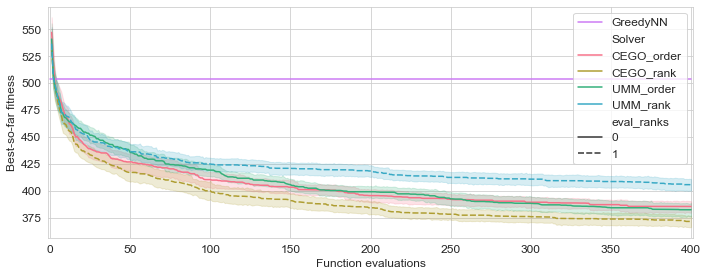

instance:  ARP_10_73
                          Fitness   size
Solver         budget                   
CEGO_order     400.0   361.591765  12000
CEGO_rank      400.0   344.205204  12000
GreedyNN_order 1.0     479.834549      1
UMM_order      400.0   358.062370  12000
UMM_rank       400.0   365.127635  12000
Saving to img/fitness_ARP_10_73.pdf


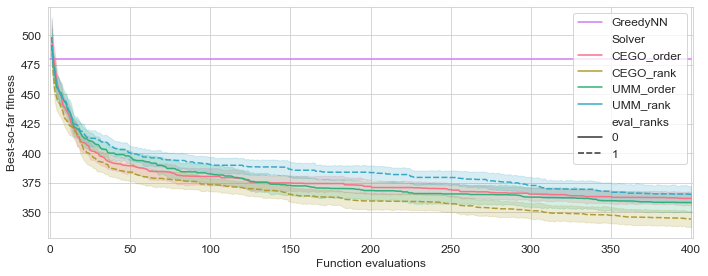

instance:  ARP_15_42
                          Fitness   size
Solver         budget                   
CEGO_order     400.0   604.167196  12000
CEGO_rank      400.0   586.762803  12000
GreedyNN_order 1.0     799.540162      1
UMM_order      400.0   599.111635  12000
UMM_rank       400.0   622.567043  12000


In [ ]:
def plot_fitness(df, inst, best = False):
    print("instance: ", inst)
    if len(df) == 0: return
    df_fitness = df.groupby(['Solver','budget','seed']).Fitness.min().reset_index()
    df_fitness = df_fitness.pivot_table(index=['Solver','budget'], values='Fitness')
    df_fitness['size'] = df.groupby(['Solver', 'budget'])['Fitness'].size()
    print(df_fitness)
    budget = df.budget.max()
    plt.figure(figsize=(10,4))
    val_opt = None #get_opt(inst)
    if val_opt is not None: 
        print("optimum: ", val_opt)
        plt.plot([0,budget],[val_opt,val_opt])
    palette = sns.color_palette("husl", df['Solver'].nunique())
    greedynn_f = df.loc[df.Solver.str.startswith("GreedyNN"), "Fitness"]
    if len(greedynn_f) > 0:
        plt.plot([0,budget],[greedynn_f,greedynn_f], label="GreedyNN", color=palette.pop())
        df = df[~df.Solver.str.startswith("GreedyNN")]
    if best:
        y_col = 'Best-so-far fitness' 
    else:
        y_col = 'Fitness'
    g = sns.lineplot(x='Function evaluations', y=y_col, hue='Solver', data=df, palette=palette, style="eval_ranks")
    g.set(xlim=(-1, budget+1))
    plt.tight_layout()
    filename = 'img/fitness_' + df.instance.iloc[0].replace('/','_').replace('.','_') + '.pdf'
    print("Saving to " + filename)
    plt.savefig(filename)
    plt.show()  

sel_inst = df.instance.unique()
for inst in sel_inst:
    #for _, gdf in df.groupby('eval_ranks'):
    #    subdf = gdf[gdf.instance.str.contains(inst)].sort_values('Solver')
    subdf = df[df.instance.str.contains(inst)].sort_values('Solver')
    plot_fitness(subdf, inst, best = True)
        

## Summary table of the results

Table with the summary of the results

In [ ]:
sel_confs = list(df.Solver.unique()) #['CEGO_rank_200', 'UMM_order_200']
# The maximum time per seed and evaluation is the final time. 
dftime = df.groupby(['Solver','Problem','Instance','seed']).run_time.max().reset_index()
dftime
# Then we calculate the mean per instance.
dftime['run_time'] =  (dftime['run_time'] / 60.0).round(1)
dftime = dftime.pivot_table(index=['Problem','Instance'], columns='Solver',values='run_time').reset_index()
dftime.columns.name  = ''
dftime
dftime = dftime[['Problem', 'Instance'] + sel_confs]
dftime#.sort_values(by='Instance')

print(dftime.to_latex(index=False))

In [ ]:
df_fitness = df.groupby(['Solver', 'Problem','Instance','seed']).Fitness.min().reset_index()
# df_fitness = df_fitness.groupby(['Solver','Problem','instance']).Fitness.agg(MeanFitness='mean').reset_index()
df_fitness = df_fitness.pivot_table(index=['Problem', 'Instance'], columns='Solver', values=['Fitness']).reset_index()

df_fitness.columns = [b if b != '' else a for (a,b)  in df_fitness.columns]
df_fitness = df_fitness[['Problem', 'Instance'] + sel_confs]
df_fitness
print(df_fitness.to_latex(index=False))

In [ ]:
# Keep only one CEGO and one UMM
df = df[df.Solver.isin(['CEGO_inv','UMM_400'])]
# Make sure we have the right data
mask = ((df.budget==400) & (df.eval_ranks==0)&((df.budgetMM == 1) | (df.budgetMM.isna())))
df = df[mask]
df.Solver = df.Solver.str.replace('CEGO_inv','CEGO').str.replace('UMM_400', 'UMM')

# The maximum time per seed and evaluation is the final time.
dftime = df.groupby(['Solver','Problem','instance','seed']).run_time.max()
# Then we calculate the mean per instance.
dftime = dftime.groupby(['Solver','Problem','instance']).mean().reset_index()
# Convert to hours
dftime['run_time'] =  (dftime['run_time'] / 3600.0).round(1)
dftime = dftime.pivot_table(index=['Problem','instance'], columns='Solver',values='run_time')
dftime.rename(columns={'CEGO':'CEGO Runtime', 'UMM':'UMM Runtime'}, inplace=True)

# FEvals of CEGO
tmp = df[df.Solver == 'CEGO'].groupby(['Problem','instance','seed'])['Function evaluations'].max()
dftime['CEGO F. evaluations'] = tmp.groupby(['Problem','instance']).mean()

# Fitness
df_fitness = df.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
tmp_cego = df_fitness[df_fitness.Solver == 'CEGO'].groupby(['Problem','instance']).Fitness.agg(CEGO_Fitness_mean='mean', CEGO_Fitness_std='std').reset_index()
tmp_umm = df_fitness[df_fitness.Solver == 'UMM'].groupby(['Problem','instance']).Fitness.agg(UMM_Fitness_mean='mean', UMM_Fitness_std='std').reset_index()
df = pd.merge(tmp_cego, tmp_umm)
df.CEGO_Fitness_mean = df.CEGO_Fitness_mean.round(1)
df.CEGO_Fitness_std = "(" + df.CEGO_Fitness_std.round(1).astype(str) + ")"
df.UMM_Fitness_mean = df.UMM_Fitness_mean.round(1)
df.UMM_Fitness_std = "(" + df.UMM_Fitness_std.round(1).astype(str) + ")"
df = pd.merge(df, dftime, on=['Problem', 'instance'])

df = df.sort_values(['Problem', 'UMM Runtime', 'CEGO Runtime'])

for inst in df.instance:
    x, y = [ f.to_numpy() for _, f in df_fitness[df_fitness.instance == inst].groupby('Solver').Fitness]
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')])).replace('(','[').replace(')', ']')
    #df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))

# Keep only some columns
df = df[['Problem', 'Instance','CEGO_Fitness_mean','CEGO_Fitness_std','UMM_Fitness_mean','UMM_Fitness_std','Confidence interval','CEGO Runtime','UMM Runtime']]
df.reset_index(drop=True)#.to_csv('info.csv')

In [ ]:
print(df.to_latex(index=False))